## Instructions {-}

1. This template serves as the required format for your code and report submission for the Prediction Problem assignment.
2. You may modify the template to improve readability or add relevant details, but it must include all requested information.
3. Ensure that your work is reproducible, meaning your code should consistently yield a metric value close to your Kaggle leaderboard score despite inherent randomness in data science.

## 1) Exploratory Data Analysis (EDA)

* Summarize key insights obtained from the dataset.
* Discuss trends, correlations, or anomalies that influenced your modeling decisions.
* Provide relevant data visualizations (e.g., histograms, scatter plots, correlation matrices) to support your findings.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

train_x = pd.read_csv("train_x.csv")
train_y_data = pd.read_csv("train_y.csv")
test = pd.read_csv("public_private_X.csv")

In [2]:
print("Number of possible predictors: ", len(train_x.columns)) 

Number of possible predictors:  28


In [3]:
# merge train_x and train_y_data on ID key
# use inner merge to only include records that are present in both datasets
train = pd.merge(train_x, train_y_data, how='inner', on='ID')

In [4]:
# find number of missing values
train.isna().sum()

ID                                         0
DIVISION_NUMBER                            0
PRODUCT_NUMBER                             0
PURCHASE_ORDER_DUE_DATE                    0
COMPANY_VENDOR_NUMBER                      0
SHIP_FROM_VENDOR                           0
ORDER_DATE                                 0
ORDER_DAY_OF_WEEK                          0
PRODUCT_CLASSIFICATION                     0
PURCHASE_ORDER_TYPE                        0
DISTANCE_IN_MILES                          0
DIVISION_CODE                              0
PURCHASE_FROM_VENDOR                       0
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET      0
ORDER_QUANTITY_DEVIATION                   0
TRANSIT_LEAD_TIME                          0
PURCHASING_LEAD_TIME                       0
DAYS_BETWEEN_ORDER_AND_DUE_DATE            0
GIVEN_TIME_TO_LEAD_TIME_RATIO              0
DUE_DATE_WEEKDAY                           0
PRODUCT_MARKET                             0
RESERVABLE_INDICATOR                       0
PRODUCT_ST

In [5]:
# print data type of each column
train.dtypes

ID                                         int64
DIVISION_NUMBER                            int64
PRODUCT_NUMBER                             int64
PURCHASE_ORDER_DUE_DATE                   object
COMPANY_VENDOR_NUMBER                      int64
SHIP_FROM_VENDOR                           int64
ORDER_DATE                                object
ORDER_DAY_OF_WEEK                          int64
PRODUCT_CLASSIFICATION                     int64
PURCHASE_ORDER_TYPE                        int64
DISTANCE_IN_MILES                        float64
DIVISION_CODE                             object
PURCHASE_FROM_VENDOR                       int64
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    float64
ORDER_QUANTITY_DEVIATION                 float64
TRANSIT_LEAD_TIME                        float64
PURCHASING_LEAD_TIME                     float64
DAYS_BETWEEN_ORDER_AND_DUE_DATE            int64
GIVEN_TIME_TO_LEAD_TIME_RATIO            float64
DUE_DATE_WEEKDAY                           int64
PRODUCT_MARKET      

In [6]:
# convert date columns to datetime then numeric
train["PURCHASE_ORDER_DUE_DATE"] = pd.to_datetime(train["PURCHASE_ORDER_DUE_DATE"])
test["PURCHASE_ORDER_DUE_DATE"] = pd.to_datetime(test["PURCHASE_ORDER_DUE_DATE"])
train["ORDER_DATE"] = pd.to_datetime(train["ORDER_DATE"])
test["ORDER_DATE"] = pd.to_datetime(test["ORDER_DATE"])

train["PURCHASE_ORDER_DUE_DATE"] = train["PURCHASE_ORDER_DUE_DATE"].astype(int) / 10**9
test["PURCHASE_ORDER_DUE_DATE"] = test["PURCHASE_ORDER_DUE_DATE"].astype(int) / 10**9
train["ORDER_DATE"] = train["ORDER_DATE"].astype(int) / 10**9
test["ORDER_DATE"] = test["ORDER_DATE"].astype(int) / 10**9

In [7]:
train["DIVISION_CODE"].value_counts()

DIVISION_CODE
9P    10034
6Z     6405
3Y     3974
Name: count, dtype: int64

In [8]:
# division code is redundant since we have division_number
train.drop(columns=['DIVISION_CODE'], inplace=True)
test.drop(columns=['DIVISION_CODE'], inplace=True)

In [9]:
# reservable_indicator values
train["RESERVABLE_INDICATOR"].value_counts()

RESERVABLE_INDICATOR
Y    20413
Name: count, dtype: int64

In [10]:
# drop reservable_indicator column because it has only one value
train.drop(columns=['RESERVABLE_INDICATOR'], inplace=True)
test.drop(columns=['RESERVABLE_INDICATOR'], inplace=True)

# drop other columns with 0 variance
train = train.loc[:, train.var() != 0]
test = test.loc[:, test.var() != 0]


In [11]:
# drop ID column
train.drop(columns=['ID', "DIVISION_NUMBER", "PRODUCT_NUMBER"], inplace=True)
test.drop(columns=['ID', "DIVISION_NUMBER", "PRODUCT_NUMBER"], inplace=True)

In [12]:
train.describe()

,PURCHASE_ORDER_DUE_DATE,COMPANY_VENDOR_NUMBER,SHIP_FROM_VENDOR,ORDER_DATE,ORDER_DAY_OF_WEEK,PRODUCT_CLASSIFICATION,PURCHASE_ORDER_TYPE,DISTANCE_IN_MILES,PURCHASE_FROM_VENDOR,AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET,...,DAYS_BETWEEN_ORDER_AND_DUE_DATE,GIVEN_TIME_TO_LEAD_TIME_RATIO,DUE_DATE_WEEKDAY,PRODUCT_MARKET,AVERAGE_DAILY_DEMAND_CASES,AVERAGE_VENDOR_ORDER_CYCLE_DAYS,AVERAGE_ORDER_CYCLE_DAYS,AVERAGE_ORDER_CYCLE_CASES,LEAD_TIME_TO_DISTANCE_RATIO,ON_TIME_AND_COMPLETE
count,2.041300e+04,20413.000000,20413.000000,2.041300e+04,20413.000000,20413.000000,20413.000000,20413.000000,20413.000000,20413.000000,...,20413.000000,20413.000000,20413.000000,20413.000000,20372.000000,20074.000000,20074.000000,20074.000000,20413.000000,20413.000000
mean,1.408184e+09,635.119385,502.719933,1.407094e+09,3.522216,20.401362,0.741341,705.445769,1370.992652,57.256706,...,12.614363,1.055579,3.297164,3223.617989,6.539021,11.571033,15.522679,67.304358,0.057917,0.488855
std,3.044341e+06,530.675020,471.383574,2.853682e+06,2.241704,12.318800,0.437908,662.947538,724.403780,109.089098,...,13.868953,0.580129,2.183070,1812.570273,12.030471,22.907049,26.904661,131.104278,0.123819,0.499888
min,1.402877e+09,0.000000,1.000000,1.401754e+09,0.000000,0.000000,0.000000,5.530000,0.000000,1.000000,...,0.000000,0.000000,0.000000,100.000000,0.010000,1.000000,1.000000,1.000000,0.002000,0.000000
25%,1.405642e+09,122.000000,104.000000,1.404778e+09,1.000000,9.000000,0.000000,198.060000,798.000000,12.690000,...,6.000000,0.880000,1.000000,1665.000000,1.230000,7.000000,7.000000,15.000000,0.012000,0.000000
50%,1.408061e+09,415.000000,397.000000,1.407197e+09,4.000000,21.000000,1.000000,562.290000,1578.000000,28.800000,...,9.000000,1.000000,4.000000,3193.000000,2.930000,7.000000,8.264669,32.947833,0.020000,0.000000
75%,1.410480e+09,1295.000000,743.000000,1.409357e+09,5.000000,34.000000,1.000000,979.620000,1974.000000,64.000000,...,15.000000,1.050000,5.000000,4804.000000,6.980000,9.887250,16.640615,71.079551,0.045000,1.000000
max,1.418947e+09,1801.000000,1880.000000,1.412035e+09,6.000000,39.000000,1.000000,3124.120000,2723.000000,3276.000000,...,140.000000,29.000000,6.000000,6392.000000,182.870000,365.000000,777.691012,3367.544034,2.532000,1.000000


<Axes: >

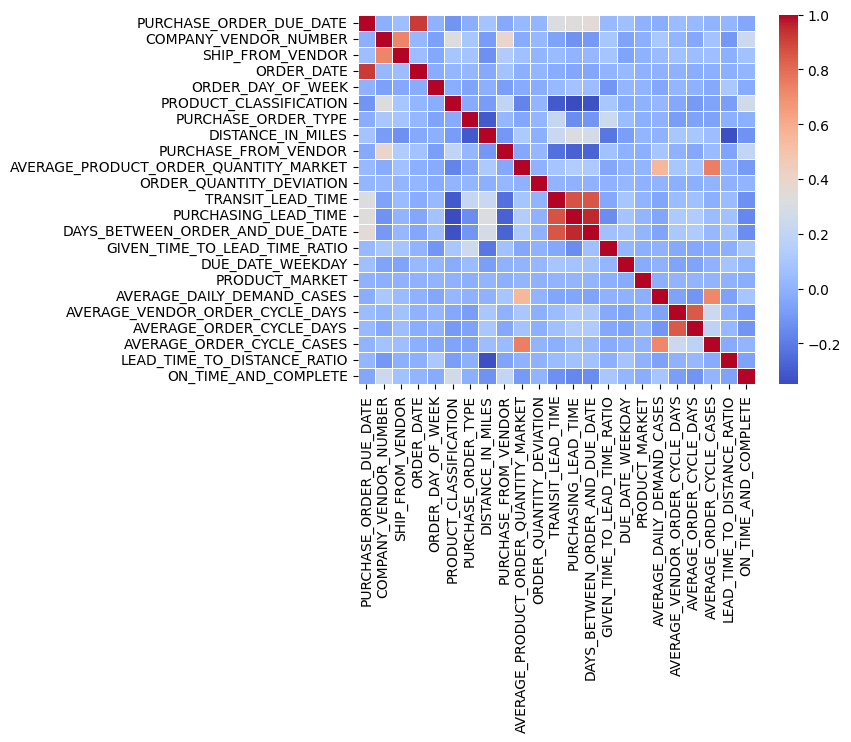

In [13]:
corr_matrix = train.corr()
# plot corr_matrix as heatmap
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)


In [14]:
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs != 1]  

# Find feature pairs with high correlation
print(high_corr_pairs[high_corr_pairs > 0.8])

PURCHASING_LEAD_TIME             DAYS_BETWEEN_ORDER_AND_DUE_DATE    0.957562
DAYS_BETWEEN_ORDER_AND_DUE_DATE  PURCHASING_LEAD_TIME               0.957562
ORDER_DATE                       PURCHASE_ORDER_DUE_DATE            0.919453
PURCHASE_ORDER_DUE_DATE          ORDER_DATE                         0.919453
PURCHASING_LEAD_TIME             TRANSIT_LEAD_TIME                  0.864590
TRANSIT_LEAD_TIME                PURCHASING_LEAD_TIME               0.864590
                                 DAYS_BETWEEN_ORDER_AND_DUE_DATE    0.853955
DAYS_BETWEEN_ORDER_AND_DUE_DATE  TRANSIT_LEAD_TIME                  0.853955
AVERAGE_VENDOR_ORDER_CYCLE_DAYS  AVERAGE_ORDER_CYCLE_DAYS           0.843005
AVERAGE_ORDER_CYCLE_DAYS         AVERAGE_VENDOR_ORDER_CYCLE_DAYS    0.843005
dtype: float64


<Axes: ylabel='Frequency'>

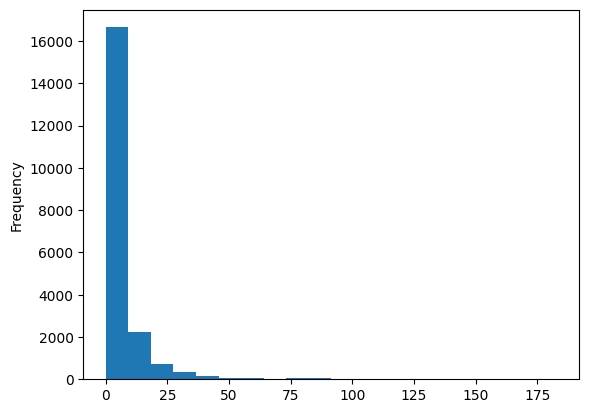

In [15]:
# plot AVERAGE_DAILY_DEMAND_CASES 
train["AVERAGE_DAILY_DEMAND_CASES"].plot(kind="hist", bins = 20)

<Axes: ylabel='Frequency'>

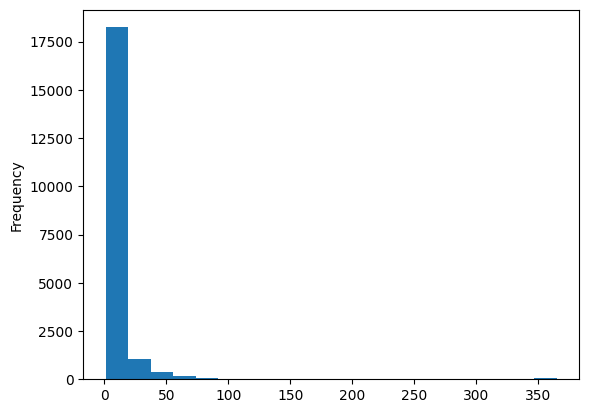

In [16]:
# plot AVERAGE_VENDOR_ORDER_CYCLE_DAYS
train["AVERAGE_VENDOR_ORDER_CYCLE_DAYS"].plot(kind="hist", bins = 20)

<Axes: ylabel='Frequency'>

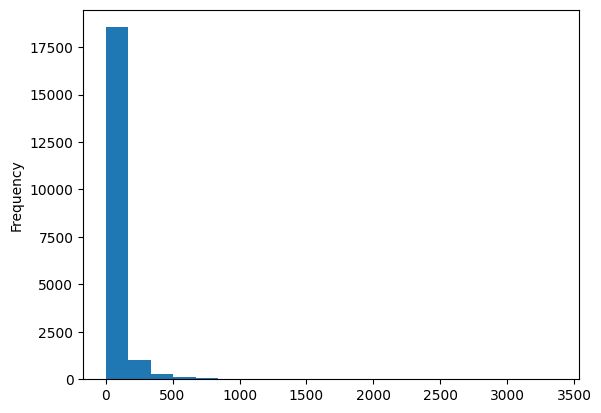

In [17]:
# plot average order cycle cases
train["AVERAGE_ORDER_CYCLE_CASES"].plot(kind="hist", bins = 20)

In [18]:
# find the most skewed features to later apply log transformation

from scipy.stats import skew

skewness = train.apply(skew).sort_values(ascending=False)

print(skewness[skewness > 1])  


GIVEN_TIME_TO_LEAD_TIME_RATIO            12.999634
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    10.062938
LEAD_TIME_TO_DISTANCE_RATIO               7.302515
TRANSIT_LEAD_TIME                         4.587762
PURCHASING_LEAD_TIME                      4.246705
DAYS_BETWEEN_ORDER_AND_DUE_DATE           4.237840
ORDER_QUANTITY_DEVIATION                  1.407500
SHIP_FROM_VENDOR                          1.050264
DISTANCE_IN_MILES                         1.038973
dtype: float64


In [19]:
train.isna().sum()

PURCHASE_ORDER_DUE_DATE                    0
COMPANY_VENDOR_NUMBER                      0
SHIP_FROM_VENDOR                           0
ORDER_DATE                                 0
ORDER_DAY_OF_WEEK                          0
PRODUCT_CLASSIFICATION                     0
PURCHASE_ORDER_TYPE                        0
DISTANCE_IN_MILES                          0
PURCHASE_FROM_VENDOR                       0
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET      0
ORDER_QUANTITY_DEVIATION                   0
TRANSIT_LEAD_TIME                          0
PURCHASING_LEAD_TIME                       0
DAYS_BETWEEN_ORDER_AND_DUE_DATE            0
GIVEN_TIME_TO_LEAD_TIME_RATIO              0
DUE_DATE_WEEKDAY                           0
PRODUCT_MARKET                             0
AVERAGE_DAILY_DEMAND_CASES                41
AVERAGE_VENDOR_ORDER_CYCLE_DAYS          339
AVERAGE_ORDER_CYCLE_DAYS                 339
AVERAGE_ORDER_CYCLE_CASES                339
LEAD_TIME_TO_DISTANCE_RATIO                0
ON_TIME_AN

## 2) Data Preprocessing

Describe any preprocessing steps performed on your dataset. This may include imputing missing values, creating dummy variables, combining levels of categorical variable(s), discarding predictors that are not useful, etc.

In [20]:
# since the four features with missing values are skewed right, impute with median
train["AVERAGE_DAILY_DEMAND_CASES"] = train["AVERAGE_DAILY_DEMAND_CASES"].fillna(train["AVERAGE_DAILY_DEMAND_CASES"].median())
test["AVERAGE_DAILY_DEMAND_CASES"] = test["AVERAGE_DAILY_DEMAND_CASES"].fillna(test["AVERAGE_DAILY_DEMAND_CASES"].median())
train["AVERAGE_VENDOR_ORDER_CYCLE_DAYS"] = train["AVERAGE_VENDOR_ORDER_CYCLE_DAYS"].fillna(train["AVERAGE_VENDOR_ORDER_CYCLE_DAYS"].median())
test["AVERAGE_VENDOR_ORDER_CYCLE_DAYS"] = test["AVERAGE_VENDOR_ORDER_CYCLE_DAYS"].fillna(test["AVERAGE_VENDOR_ORDER_CYCLE_DAYS"].median())
train["AVERAGE_ORDER_CYCLE_DAYS"] = train["AVERAGE_ORDER_CYCLE_DAYS"].fillna(train["AVERAGE_ORDER_CYCLE_DAYS"].median())
test["AVERAGE_ORDER_CYCLE_DAYS"] = test["AVERAGE_ORDER_CYCLE_DAYS"].fillna(test["AVERAGE_ORDER_CYCLE_DAYS"].median())
train["AVERAGE_ORDER_CYCLE_CASES"] = train["AVERAGE_ORDER_CYCLE_CASES"].fillna(train["AVERAGE_ORDER_CYCLE_CASES"].median())
test["AVERAGE_ORDER_CYCLE_CASES"] = test["AVERAGE_ORDER_CYCLE_CASES"].fillna(test["AVERAGE_ORDER_CYCLE_CASES"].median())
train.isna().sum()

PURCHASE_ORDER_DUE_DATE                  0
COMPANY_VENDOR_NUMBER                    0
SHIP_FROM_VENDOR                         0
ORDER_DATE                               0
ORDER_DAY_OF_WEEK                        0
PRODUCT_CLASSIFICATION                   0
PURCHASE_ORDER_TYPE                      0
DISTANCE_IN_MILES                        0
PURCHASE_FROM_VENDOR                     0
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    0
ORDER_QUANTITY_DEVIATION                 0
TRANSIT_LEAD_TIME                        0
PURCHASING_LEAD_TIME                     0
DAYS_BETWEEN_ORDER_AND_DUE_DATE          0
GIVEN_TIME_TO_LEAD_TIME_RATIO            0
DUE_DATE_WEEKDAY                         0
PRODUCT_MARKET                           0
AVERAGE_DAILY_DEMAND_CASES               0
AVERAGE_VENDOR_ORDER_CYCLE_DAYS          0
AVERAGE_ORDER_CYCLE_DAYS                 0
AVERAGE_ORDER_CYCLE_CASES                0
LEAD_TIME_TO_DISTANCE_RATIO              0
ON_TIME_AND_COMPLETE                     0
dtype: int6

In [21]:
# drop columns with lowest correlation values with response (from corr_matrix)
train.drop(columns = ["PRODUCT_CLASSIFICATION", "COMPANY_VENDOR_NUMBER", "PURCHASE_FROM_VENDOR"], inplace=True)
test.drop(columns = ["PRODUCT_CLASSIFICATION", "COMPANY_VENDOR_NUMBER", "PURCHASE_FROM_VENDOR"], inplace=True)

In [22]:
# drop columns in highly correlated pairs and columns that can be inferred from others
train.drop(columns = ["PURCHASING_LEAD_TIME", "PURCHASE_ORDER_DUE_DATE", "AVERAGE_VENDOR_ORDER_CYCLE_DAYS", "TRANSIT_LEAD_TIME"], inplace=True)
test.drop(columns = ["PURCHASING_LEAD_TIME", "PURCHASE_ORDER_DUE_DATE", "AVERAGE_VENDOR_ORDER_CYCLE_DAYS", "TRANSIT_LEAD_TIME"], inplace=True)

In [23]:
from numpy import log1p

# apply log transformation to skewed features
skewed_features = [
    'GIVEN_TIME_TO_LEAD_TIME_RATIO', 
    'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 
    'LEAD_TIME_TO_DISTANCE_RATIO', 
    'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 
    'ORDER_QUANTITY_DEVIATION', 
    'SHIP_FROM_VENDOR', 
    'DISTANCE_IN_MILES'
]

train[skewed_features] = train[skewed_features].apply(log1p)
test[skewed_features] = test[skewed_features].apply(log1p)

In [24]:
train_x_data = train.drop(columns = ["ON_TIME_AND_COMPLETE"])

In [25]:
# one-hot encode PURCHASE_ORDER_TYPE, DUE_DATE_WEEKDAY, ORDER_DAY_OF_WEEK
cat_vars = ["PURCHASE_ORDER_TYPE", "DUE_DATE_WEEKDAY", "ORDER_DAY_OF_WEEK"]
train_x_data = pd.get_dummies(train_x_data, columns=cat_vars)
test = pd.get_dummies(test, columns=cat_vars)


In [26]:
# use StandardScaler to scale all other features besides categorical features
scaler = StandardScaler()

x_train_scaled = train_x_data.copy()
num_vars = train_x_data.select_dtypes(include=['number']).columns
x_train_scaled[num_vars] = scaler.fit_transform(train_x_data[num_vars])

test_scaled = test.copy()
test_scaled[num_vars] = scaler.transform(test[num_vars])

x_train_scaled.describe()

,SHIP_FROM_VENDOR,ORDER_DATE,DISTANCE_IN_MILES,AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET,ORDER_QUANTITY_DEVIATION,DAYS_BETWEEN_ORDER_AND_DUE_DATE,GIVEN_TIME_TO_LEAD_TIME_RATIO,PRODUCT_MARKET,AVERAGE_DAILY_DEMAND_CASES,AVERAGE_ORDER_CYCLE_DAYS,AVERAGE_ORDER_CYCLE_CASES,LEAD_TIME_TO_DISTANCE_RATIO
count,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04,2.041300e+04
mean,1.552452e-16,-1.109690e-15,6.791108e-16,-3.153636e-16,3.759301e-17,5.729454e-16,3.400775e-16,-5.047210e-17,-5.464910e-17,-5.517123e-17,8.771703e-17,7.240136e-17
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-3.670146e+00,-1.871362e+00,-2.873169e+00,-2.404839e+00,-3.151945e+00,-3.117982e+00,-3.598276e+00,-1.723351e+00,-5.426140e-01,-5.394915e-01,-5.053260e-01,-5.479135e-01
25%,-7.040633e-01,-8.116522e-01,-4.217879e-01,-6.939715e-01,-6.346264e-01,-5.072821e-01,-3.467097e-01,-8.599149e-01,-4.411095e-01,-3.147369e-01,-3.969657e-01,-4.380364e-01
50%,2.937825e-01,3.611546e-02,3.244074e-01,-2.121812e-03,5.625598e-03,-2.875465e-02,-2.800071e-02,-1.689244e-02,-2.996689e-01,-2.673635e-01,-2.597283e-01,-3.509137e-01
75%,7.622593e-01,7.930509e-01,7.221081e-01,6.915389e-01,5.689116e-01,6.018185e-01,9.918644e-02,8.719225e-01,3.479670e-02,4.231442e-02,2.510881e-02,-8.299420e-02
max,1.456837e+00,1.731651e+00,1.553566e+00,4.178434e+00,6.162630e+00,3.521445e+00,1.392067e+01,1.748048e+00,1.467141e+01,2.855466e+01,2.537485e+01,1.339192e+01


In [33]:
test_scaled.isna().sum()

SHIP_FROM_VENDOR                         0
ORDER_DATE                               0
DISTANCE_IN_MILES                        0
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET    0
ORDER_QUANTITY_DEVIATION                 0
DAYS_BETWEEN_ORDER_AND_DUE_DATE          3
GIVEN_TIME_TO_LEAD_TIME_RATIO            0
PRODUCT_MARKET                           0
AVERAGE_DAILY_DEMAND_CASES               0
AVERAGE_ORDER_CYCLE_DAYS                 0
AVERAGE_ORDER_CYCLE_CASES                0
LEAD_TIME_TO_DISTANCE_RATIO              0
PURCHASE_ORDER_TYPE_0                    0
PURCHASE_ORDER_TYPE_1                    0
DUE_DATE_WEEKDAY_0                       0
DUE_DATE_WEEKDAY_1                       0
DUE_DATE_WEEKDAY_2                       0
DUE_DATE_WEEKDAY_3                       0
DUE_DATE_WEEKDAY_4                       0
DUE_DATE_WEEKDAY_5                       0
DUE_DATE_WEEKDAY_6                       0
ORDER_DAY_OF_WEEK_0                      0
ORDER_DAY_OF_WEEK_1                      0
ORDER_DAY_O

## 3) Feature Engineering

* List and explain the new features you created (if any).
* Justify why these features were added and how they contribute to improving the model.

Mention the logical/intuitive steps you took to obtain the final model. This may include identifying transformations, significant interactions, variable selection, etc. You do not need to put any code here.

First, I imputed the missing values for the four columns that had NaN values. I used median imputation since all 4 columns were skewed so the median would be less sensitive to outliers. Next, I identified the columns which were significantly skewed, and applied a log transformation to them. I also dropped one column in each high-correlation pair (which I found through the correlation matrix that I printed in EDA) and also dropped the columns with the lowest correlation values with the response. Then, I one-hot encoded the categorical variable columns to create dummy variables. Finally, I used StandardScaler to scale all other features besides categorical features.

## 4) Model Selection and Training

Put your model here.

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

x_train = x_train_scaled
y_train = train["ON_TIME_AND_COMPLETE"]

# include up to degree 2 polynomial features, include interaction terms
# include imputation in pipeline because test data contains nan values where train data doesnt
model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(C=.05, solver='lbfgs', max_iter=1000))  
])

accuracy_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')

print(accuracy_scores)


[0.74846926 0.75753123 0.74650992 0.76090152 0.76188143]


In [71]:
model.fit(x_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('logreg', LogisticRegression(C=0.05, max_iter=1000))])

## 5) Model Prediction and Evaluation

In [72]:

y_pred = model.predict(test_scaled)

print("Predicted Labels:", y_pred)


Predicted Labels: [1 1 0 ... 1 0 1]


In [73]:
original_test = pd.read_csv("public_private_X.csv")
submission = pd.DataFrame({"ID": original_test["ID"], "ON_TIME_AND_COMPLETE": y_pred})
submission.to_csv("interim_report.csv", index=False)

Please note that your code for Questions 2, 4, and 5 will be executed sequentially, and it should generate a metric value close to the one displayed next to your name on the Kaggle leaderboard. While minor variations due to randomness in data science are expected, your implementation must be consistent and reproducible to receive full credit.

## 6) Reflection and Challenges

* Discuss any challenges faced during this process and how they were addressed.
* Mention any improvements you would make for the next steps

The biggest challenges I faced were both near the end of this process. First, I found that the test dataset contained NaN values in a column which the training dataset did not contain NaN values in. To fix this, I had to include a SimpleImpute in the pipeline. Second, my original iteration of the model with degree = 3 and C = 0.1 resulted in high k-fold accuracy scores of around 0.8, but ended up overfitting the training data because the test score was 0.72. Thus, I had to reduce the degree to 2 and tweak the c value to 0.05. 

In the future, I want to do more work tuning the hyperparameters to approach a higher accuracy.